In [34]:
# Download the test image, utils files, imutils and tesseract
!wget --no-check-certificate \
    https://raw.githubusercontent.com/Hanzo-neverdie/CV-Assignment1/refs/heads/main/image_3.jpg \
    -O image.jpg
!wget --no-check-certificate \
    https://github.com/Hanzo-neverdie/CV-Assignment1/raw/refs/heads/main/frozen_east_text_detection.pb \
    -O frozen_east_text_detection.pb
!wget --no-check-certificate \
    https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/utils/common.py \
    -O common.py
!pip install --upgrade imutils
!sudo apt install tesseract-ocr libtesseract-dev
!pip -q install pytesseract

# Imports opencv and utils
from imutils.object_detection import non_max_suppression # fix issue of NMSBoxes function
import cv2 #opencv itself
import common #some useful opencv functions
import numpy as np # matrix manipulations
import time # timer
import pytesseract # tool to extract text from the detected regions

#the following are to do with this interactive notebook code
%matplotlib inline
from matplotlib import pyplot as plt # this lets you draw inline pictures in the notebooks
import pylab # this allows you to control figure size
pylab.rcParams['figure.figsize'] = (10.0, 8.0) # this controls figure size in the notebook


--2024-09-28 18:32:32--  https://raw.githubusercontent.com/Hanzo-neverdie/CV-Assignment1/refs/heads/main/image_3.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 284511 (278K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>] 277.84K  --.-KB/s    in 0.007s  

2024-09-28 18:32:32 (36.8 MB/s) - ‘image.jpg’ saved [284511/284511]

--2024-09-28 18:32:32--  https://github.com/Hanzo-neverdie/CV-Assignment1/raw/refs/heads/main/frozen_east_text_detection.pb
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Hanzo-neverdie/CV-Assignment1/refs/heads/main/frozen_east_text_d

uint8
uint8


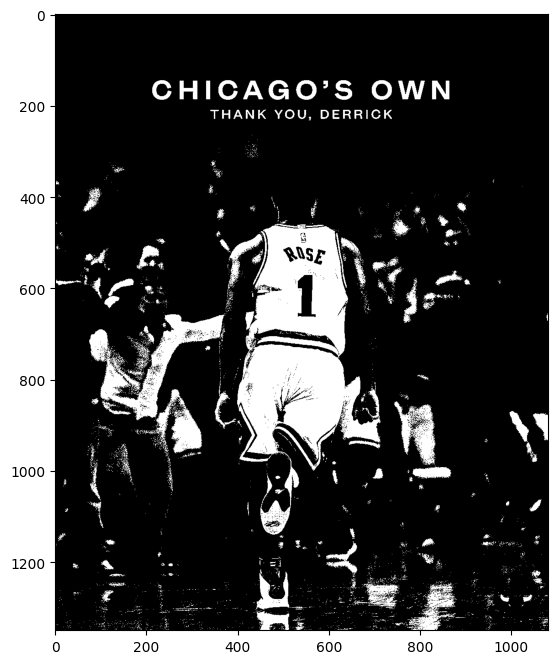

In [61]:
# Load an image
input_image = cv2.imread('image.jpg')

#grayscale it
gray = cv2.cvtColor(input_image,cv2.COLOR_BGR2GRAY)

# Noise reduction using Gaussian blurring
d = 3
img_blur = cv2.GaussianBlur(input_image, (2*d+1, 2*d+1), -1)[d:-d,d:-d]
img_blur2 = cv2.medianBlur(input_image, 5)

# Thresholding
img_threshold = cv2.threshold(gray, 128, 255, cv2.THRESH_OTSU)[1]

# Edge detection
edgeresult = input_image.copy()
edge = cv2.Canny(gray, 100, 200)

edgeresult[edge != 0] = (0, 255, 0) # this takes pixels in edgeresult where edge non-zero colours them bright green

plt.imshow(cv2.cvtColor(img_threshold,cv2.COLOR_BGR2RGB))

In [49]:
# load the input image and grab the image dimensions
image = img_blur
orig = image.copy()
(H, W) = image.shape[:2]
# set the new width and height and then determine the ratio in change
# for both the width and height
(newW, newH) = (320, 640)
rW = W / float(newW)
rH = H / float(newH)
# resize the image and grab the new image dimensions
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

In [50]:
# define the two output layer names for the EAST detector model that
# we are interested -- the first is the output probabilities and the
# second can be used to derive the bounding box coordinates of text
layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]

In [58]:
# load the pre-trained EAST text detector
print("[INFO] loading EAST text detector...")
net = cv2.dnn.readNet('frozen_east_text_detection.pb')
# construct a blob from the image and then perform a forward pass of
# the model to obtain the two output layer sets
blob = cv2.dnn.blobFromImage(input_image, 1.0, (W, H),
	(123.68, 116.78, 103.94), swapRB=True, crop=False)
start = time.time()
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
end = time.time()
# show timing information on text prediction
print("[INFO] text detection took {:.6f} seconds".format(end - start))

[INFO] loading EAST text detector...
[INFO] text detection took 0.870545 seconds


In [39]:
# grab the number of rows and columns from the scores volume, then
# initialize our set of bounding box rectangles and corresponding
# confidence scores
(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []
# loop over the number of rows
for y in range(0, numRows):
	# extract the scores (probabilities), followed by the geometrical
	# data used to derive potential bounding box coordinates that
	# surround text
	scoresData = scores[0, 0, y]
	xData0 = geometry[0, 0, y]
	xData1 = geometry[0, 1, y]
	xData2 = geometry[0, 2, y]
	xData3 = geometry[0, 3, y]
	anglesData = geometry[0, 4, y]
# loop over the number of columns
	for x in range(0, numCols):
		# if our score does not have sufficient probability, ignore it
		if scoresData[x] < 0.5:
			continue
		# compute the offset factor as our resulting feature maps will
		# be 4x smaller than the input image
		(offsetX, offsetY) = (x * 4.0, y * 4.0)
		# extract the rotation angle for the prediction and then
		# compute the sin and cosine
		angle = anglesData[x]
		cos = np.cos(angle)
		sin = np.sin(angle)
		# use the geometry volume to derive the width and height of
		# the bounding box
		h = xData0[x] + xData2[x]
		w = xData1[x] + xData3[x]
		# compute both the starting and ending (x, y)-coordinates for
		# the text prediction bounding box
		endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
		endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
		startX = int(endX - w)
		startY = int(endY - h)
		# add the bounding box coordinates and probability score to
		# our respective lists
		rects.append((startX, startY, endX, endY))
		confidences.append(scoresData[x])

-1

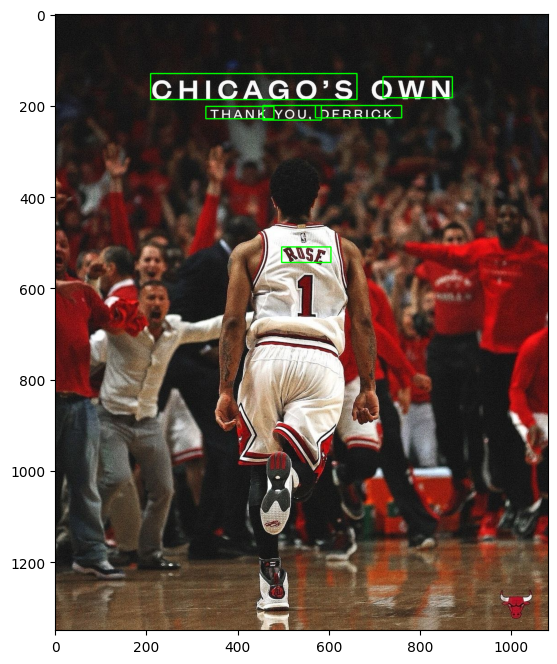

In [48]:
# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
boxes = non_max_suppression(np.array(rects), probs=confidences)
# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
	# scale the bounding box coordinates based on the respective
	# ratios
	startX = int(startX * rW)
	startY = int(startY * rH)
	endX = int(endX * rW)
	endY = int(endY * rH)
	# draw the bounding box on the image
	cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)
# show the output image
plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
cv2.waitKey(0)

In [62]:
# extract text from the image
print(pytesseract.image_to_string(orig, lang='eng'))

CHICAGO’S OWN

THANK YOU, DERRICK

 

